# Chapter 7. 머신러닝 데이터 분석

## 4. 군집

* Clustering
* 데이터의 여러 속성을 분석하여 서로 비슷한 특징을 갖는 데이터끼리 같은 클러스터(집단)으로 묶는 알고리즘
* 다른 클러스터 간에는 서로 완전하게 구분되는 특징을 갖기 때문에 어느 클러스터에도 속하지 못하는 데이터 존재할 수 있음 -> 이상값, 중복값 찾기 용이
* 비지도 학습 -> 정답이 없는 상태에서 데이터 자체의 유사성만을 기준으로 분류
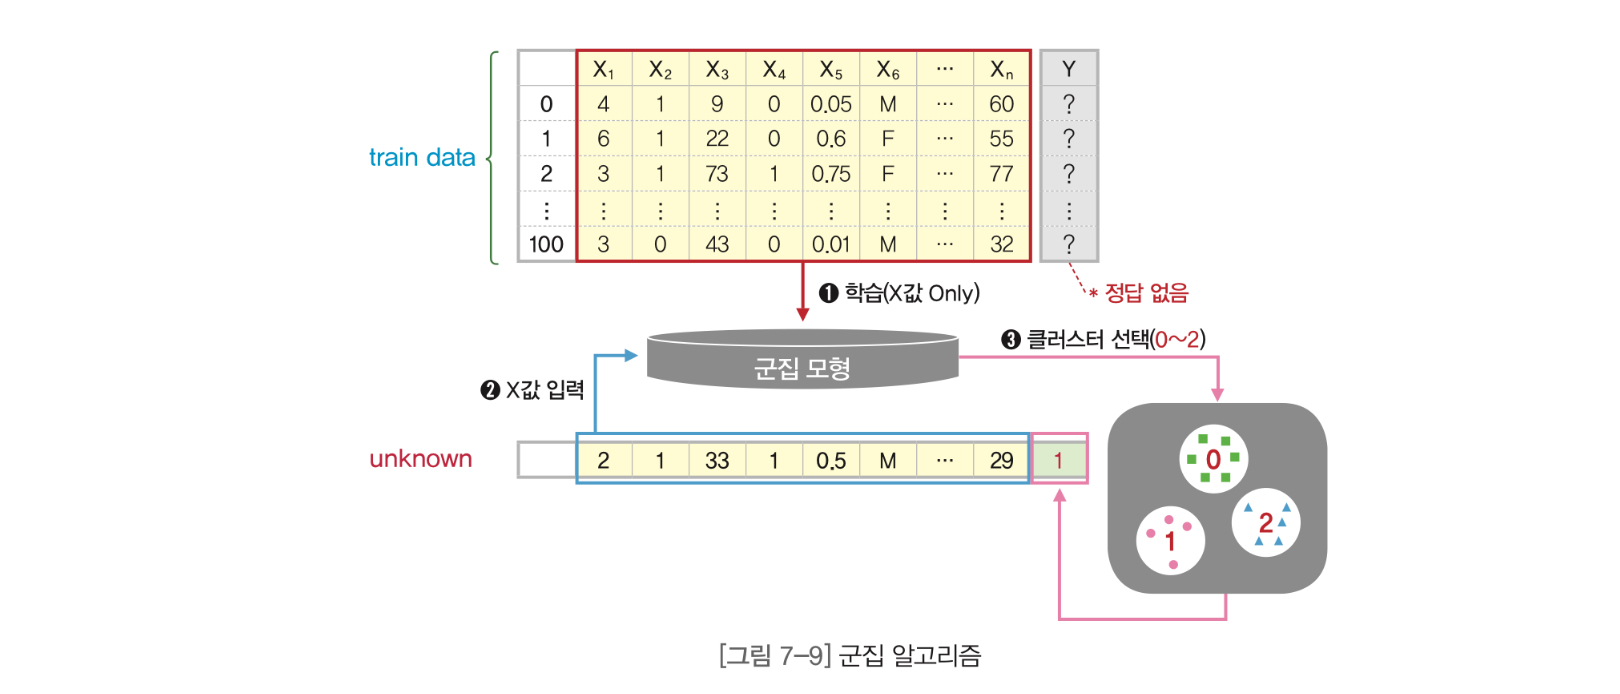

* 신용카드 부정 사용 탐지, 구매 패턴 분석 등 소비자 행동 특성을 그룹화하는데 사용
* K-Means, DBSCAN

### 4-1. K-Means

* 각 클러스터의 중심까지의 거리 이용
* 다른 클러스터 간에는 서로 완전하게 구분하기 위하여 일정한 거리 이상 떨어져야 함
* 새로운 데이터가 주어졌을 때, 벡터 공간 상 중심과 가까운 클러스터에 할당
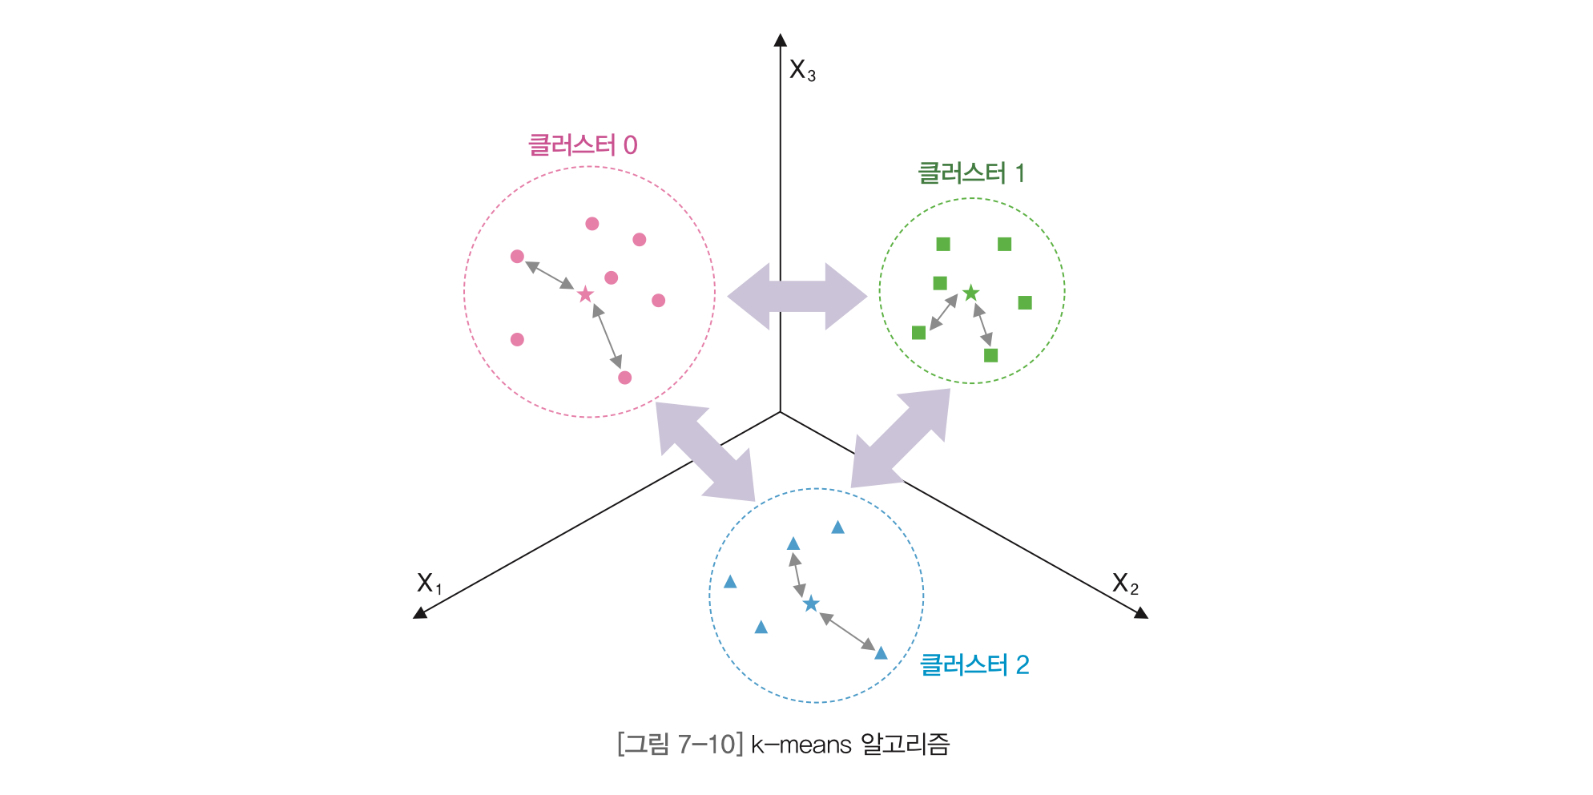

#### 1. 데이터 준비

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

In [15]:
# Wholesale customers 데이터셋 가져오기 (출처: UCI ML Repository)
# 구매 금액 / Channel: 호텔/레스토랑, 소매점 등 판매채널

uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(uci_path, header=0)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### 2.  데이터 탐색

In [16]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [17]:
# 데이터 통계 요약정보 확인
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


#### 3. 데이터 전처리

* Scaler : 스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다.

In [18]:
# 설명 변수 데이터를 정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(df).transform(df)

X[:5]

array([[ 1.44865163,  0.59066829,  0.05293319,  0.52356777, -0.04111489,
        -0.58936716, -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197,  0.54445767,  0.17031835,
        -0.27013618,  0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926,  0.40853771, -0.0281571 ,
        -0.13753572,  0.13323164,  2.24329255],
       [-0.69029709,  0.59066829,  0.10011141, -0.62401993, -0.3929769 ,
         0.6871443 , -0.49858822,  0.09341105],
       [ 1.44865163,  0.59066829,  0.84023948, -0.05239645, -0.07935618,
         0.17385884, -0.23191782,  1.29934689]])

#### 4. k-means 군집 모형 - sklearn 사용

In [19]:
# sklearn 라이브러리에서 cluster 군집 모형 가져오기
from sklearn import cluster

# 모형 객체 생성 
kmeans = cluster.KMeans(init='k-means++', n_clusters=5, n_init=10)

# 모형 학습
kmeans.fit(X)   

# 예측 (군집) 
cluster_label = kmeans.labels_
cluster_label[:50]

array([2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 4, 2, 2], dtype=int32)

In [20]:
# 예측 결과를 데이터프레임에 추가
df['Cluster'] = cluster_label
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,2


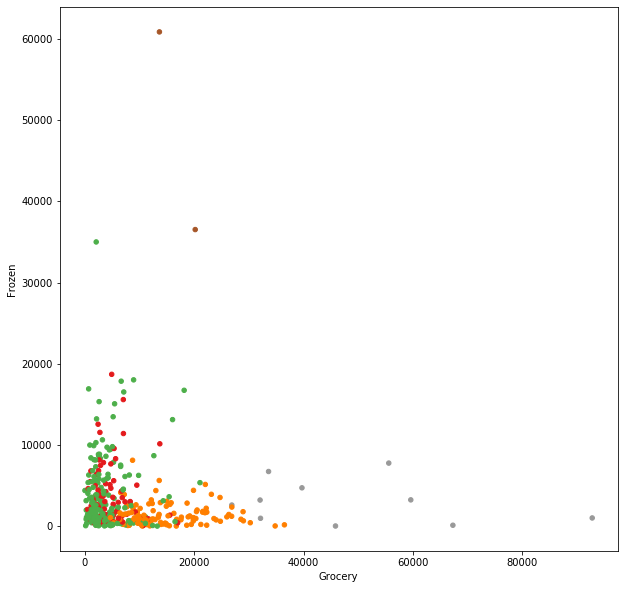

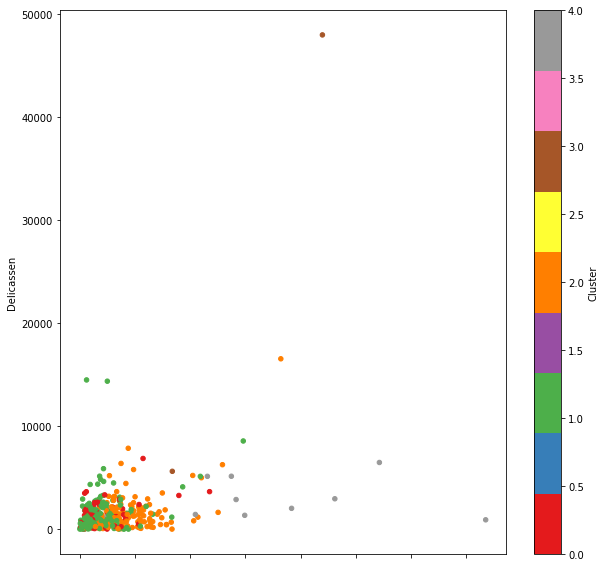

In [22]:
# 그래프로 표현 - 시각화
df.plot(kind='scatter', x='Grocery', y='Frozen', c='Cluster', cmap='Set1', 
        colorbar=False, figsize=(10, 10))
df.plot(kind='scatter', x='Milk', y='Delicassen', c='Cluster', cmap='Set1', 
        colorbar=True, figsize=(10, 10))
plt.show()
plt.close()

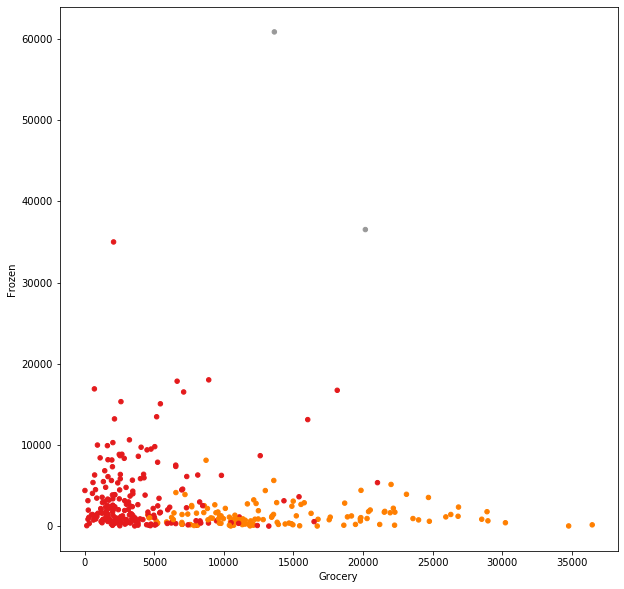

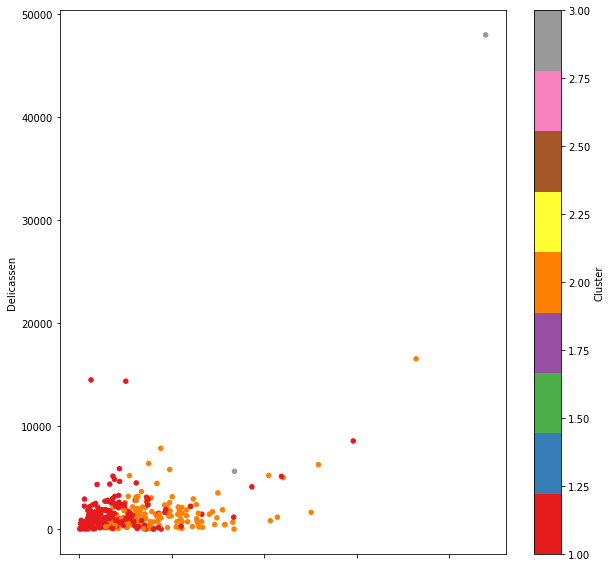

In [23]:
# 큰 값으로 구성된 클러스터(0, 4)를 제외 - 값이 몰려 있는 구간을 자세하게 분석
mask = (df['Cluster'] == 0) | (df['Cluster'] == 4)
ndf = df[~mask]

ndf.plot(kind='scatter', x='Grocery', y='Frozen', c='Cluster', cmap='Set1', 
        colorbar=False, figsize=(10, 10))
ndf.plot(kind='scatter', x='Milk', y='Delicassen', c='Cluster', cmap='Set1', 
        colorbar=True, figsize=(10, 10))
plt.show()
plt.close()

-------

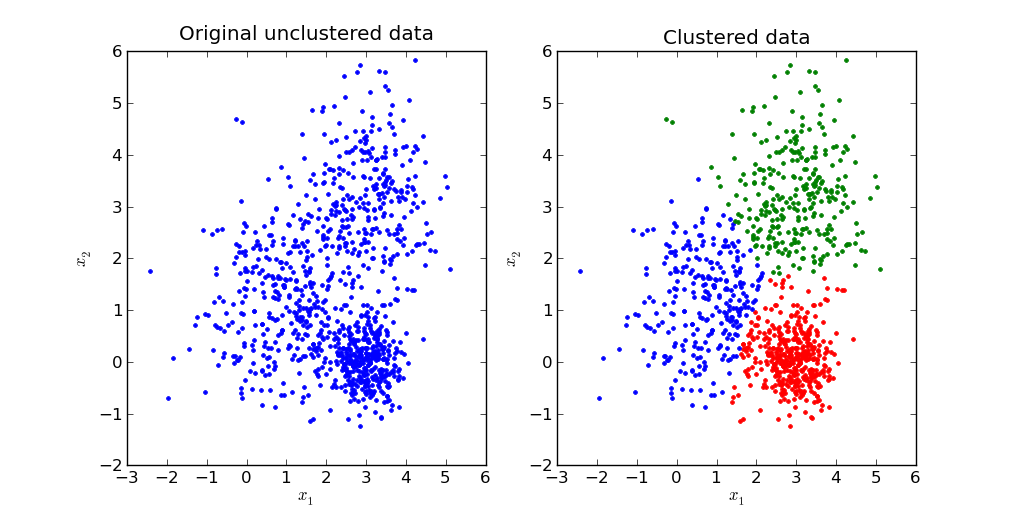

### 4-2. DBSCAN

* DBSCAN(Density-Based Spatial Clustering of Application with Noise)
* 데이터가 위치하고 있는 공간 밀집도를 기준으로 클러스터를 구분
* 자신을 중심으로 반지름 R 공간에 최소 m개의 포인트가 존재하는 지점을 코어 포인트(core point)라고 함
* 반지름 R 공간 내에 다른 코어 포인트들은 경계 포인트(border point)
* 그 외 잡음(noise)
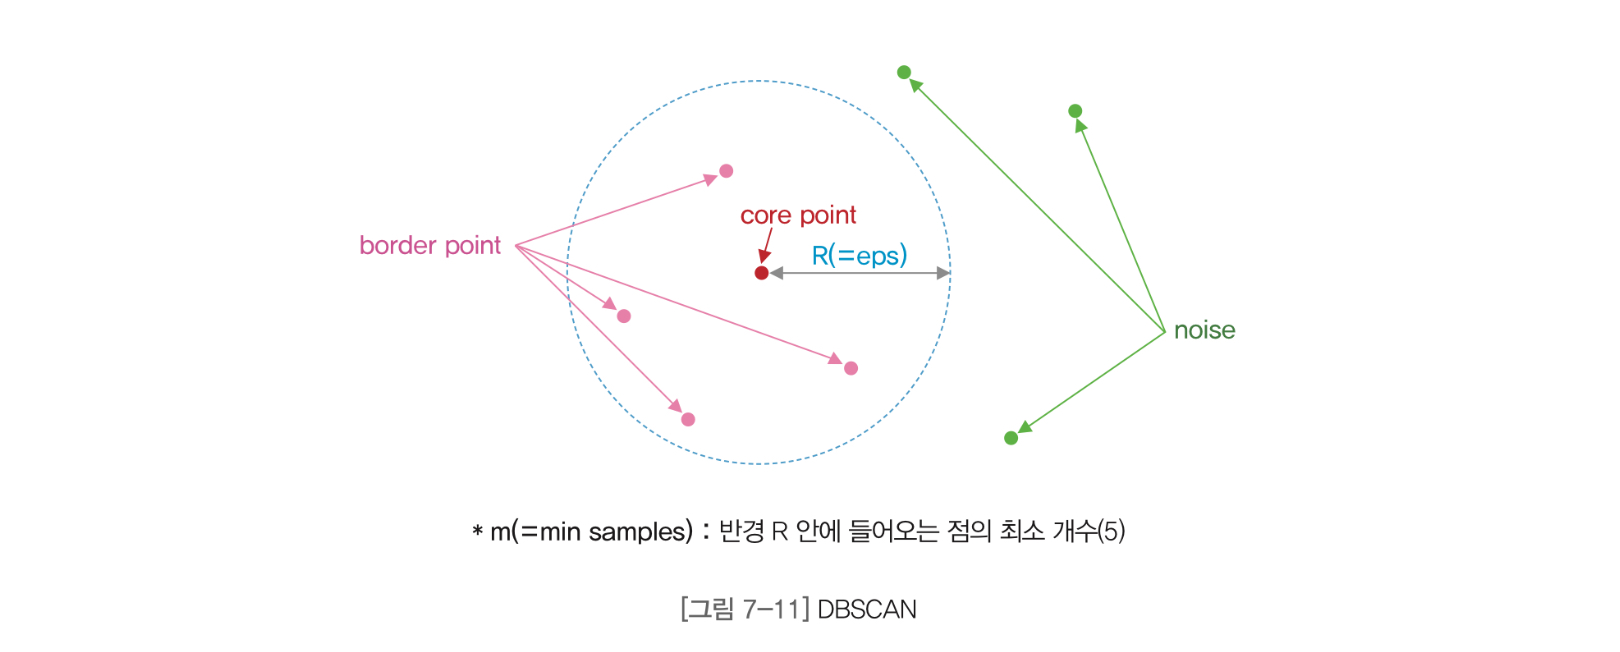

In [24]:
import folium

#### 1. 데이터 준비/ 기본 설정

In [25]:
# 서울시내 중학교 진학률 데이터셋 (출처: 교육???)
file_path = './2016_middle_shcool_graduates_report.xlsx'
df = pd.read_excel(file_path, header=0, index_col='Unnamed: 0')

# IPython Console 디스플레이 옵션 설정하기
pd.set_option('display.width', None)        # 출력화면의 너비
pd.set_option('display.max_rows', 100)      # 출력할 행의 개수 한도
pd.set_option('display.max_columns', 10)    # 출력할 열의 개수 한도
pd.set_option('display.max_colwidth', 20)   # 출력할 열의 너비
pd.set_option('display.unicode.east_asian_width', True)   # 유니코드 사용 너비 조정

# 열 이름 배열을 출력
df.head()

,지역,학교명,코드,유형,주야,...,기타진학,취업,미상,위도,경도
0,성북구,서울대학교사범대학부설중학교...,3,국립,주간,...,0.004,0,0.000,37.594942,127.038909
1,종로구,서울대학교사범대학부설여자중학교...,3,국립,주간,...,0.031,0,0.000,37.577473,127.003857
2,강남구,개원중학교,3,공립,주간,...,0.009,0,0.003,37.491637,127.071744
3,강남구,개포중학교,3,공립,주간,...,0.019,0,0.000,37.480439,127.062201
4,서초구,경원중학교,3,공립,주간,...,0.010,0,0.000,37.510750,127.008900


In [26]:
df.columns.values

array(['지역', '학교명', '코드', '유형', '주야', '남학생수', '여학생수', '일반고', '특성화고',
       '과학고', '외고_국제고', '예고_체고', '마이스터고', '자사고', '자공고', '기타진학', '취업',
       '미상', '위도', '경도'], dtype=object)

#### 2. 데이터 탐색

In [27]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지역      415 non-null    object 
 1   학교명     415 non-null    object 
 2   코드      415 non-null    int64  
 3   유형      415 non-null    object 
 4   주야      415 non-null    object 
 5   남학생수    415 non-null    int64  
 6   여학생수    415 non-null    int64  
 7   일반고     415 non-null    float64
 8   특성화고    415 non-null    float64
 9   과학고     415 non-null    float64
 10  외고_국제고  415 non-null    float64
 11  예고_체고   415 non-null    float64
 12  마이스터고   415 non-null    float64
 13  자사고     415 non-null    float64
 14  자공고     415 non-null    float64
 15  기타진학    415 non-null    float64
 16  취업      415 non-null    int64  
 17  미상      415 non-null    float64
 18  위도      415 non-null    float64
 19  경도      415 non-null    float64
dtypes: float64(12), int64(4), object(4)
memory usage: 68.1+ KB


In [28]:
# 데이터 통계 요약정보 확인
df.describe()

,코드,남학생수,여학생수,일반고,특성화고,...,기타진학,취업,미상,위도,경도
count,415.000000,415.000000,415.000000,415.000000,415.000000,...,415.000000,415.0,415.000000,415.000000,415.000000
mean,3.197590,126.532530,116.173494,0.623080,0.149684,...,0.069571,0.0,0.001670,37.491969,127.032792
std,0.804272,79.217906,76.833082,0.211093,0.102977,...,0.235630,0.0,0.003697,0.348926,0.265245
min,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,34.979940,126.639561
25%,3.000000,80.000000,71.500000,0.566500,0.065500,...,0.000000,0.0,0.000000,37.501934,126.921758
50%,3.000000,129.000000,118.000000,0.681000,0.149000,...,0.007000,0.0,0.000000,37.547702,127.013579
75%,3.000000,177.500000,161.500000,0.758000,0.224500,...,0.015000,0.0,0.003000,37.590670,127.071265
max,9.000000,337.000000,422.000000,0.908000,0.477000,...,1.000000,0.0,0.036000,37.694777,129.106974


In [29]:
# 지도에 위치 표시
mschool_map = folium.Map(location=[37.55,126.98], tiles='Stamen Terrain', 
                        zoom_start=12)
# 중학교 위치정보를 CircleMarker로 표시
for name, lat, lng in zip(df.학교명, df.위도, df.경도):
    folium.CircleMarker([lat, lng],
                        radius=5,              # 원의 반지름
                        color='brown',         # 원의 둘레 색상
                        fill=True,
                        fill_color='coral',    # 원을 채우는 색
                        fill_opacity=0.7,      # 투명도    
                        popup=name
    ).add_to(mschool_map)

mschool_map

#### 3. 데이터 전처리

In [30]:
# 원핫인코딩(더미 변수)
from sklearn import preprocessing    

label_encoder = preprocessing.LabelEncoder()     # label encoder 생성
onehot_encoder = preprocessing.OneHotEncoder()   # one hot encoder 생성

onehot_location = label_encoder.fit_transform(df['지역'])
onehot_code = label_encoder.fit_transform(df['코드'])
onehot_type = label_encoder.fit_transform(df['유형'])
onehot_day = label_encoder.fit_transform(df['주야'])

df['location'] = onehot_location
df['code'] = onehot_code
df['type'] = onehot_type
df['day'] = onehot_day

df.head()

,지역,학교명,코드,유형,주야,...,경도,location,code,type,day
0,성북구,서울대학교사범대학부설중학교...,3,국립,주간,...,127.038909,16,0,1,0
1,종로구,서울대학교사범대학부설여자중학교...,3,국립,주간,...,127.003857,22,0,1,0
2,강남구,개원중학교,3,공립,주간,...,127.071744,0,0,0,0
3,강남구,개포중학교,3,공립,주간,...,127.062201,0,0,0,0
4,서초구,경원중학교,3,공립,주간,...,127.008900,14,0,0,0


#### 4. DBSCAN 군집 모형 - sklearn 사용

In [32]:
# sklearn 라이브러리에서 cluster 군집 모형 가져오기 
from sklearn import cluster

# 분석에 사용할 속성을 선택 (과학고, 외고국제고, 자사고 진학률)
columns_list = [9, 10, 13]
X = df.iloc[:, columns_list]

X[:5]

,과학고,외고_국제고,자사고
0,0.018,0.007,0.227
1,0.000,0.035,0.043
2,0.009,0.012,0.090
3,0.013,0.013,0.065
4,0.007,0.010,0.282


In [37]:
# 설명 변수 데이터를 정규화
X = preprocessing.StandardScaler().fit(X).transform(X)

# DBSCAN 모형 객체 생성
dbm = cluster.DBSCAN(eps=0.2, min_samples=5)

# 모형 학습
dbm.fit(X)   
 
# 예측 (군집) 
cluster_label = dbm.labels_   
cluster_label[:20]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1])

In [39]:
# 예측 결과를 데이터프레임에 추가
df['Cluster'] = cluster_label
df.head()

,지역,학교명,코드,유형,주야,...,location,code,type,day,Cluster
0,성북구,서울대학교사범대학부설중학교...,3,국립,주간,...,16,0,1,0,-1
1,종로구,서울대학교사범대학부설여자중학교...,3,국립,주간,...,22,0,1,0,-1
2,강남구,개원중학교,3,공립,주간,...,0,0,0,0,-1
3,강남구,개포중학교,3,공립,주간,...,0,0,0,0,-1
4,서초구,경원중학교,3,공립,주간,...,14,0,0,0,-1


In [40]:
# 클러스터 값으로 그룹화하고, 그룹별로 내용 출력 (첫 5행만 출력)
grouped_cols = [0, 1, 3] + columns_list
grouped = df.groupby('Cluster')
for key, group in grouped:
    print('* key :', key)
    print('* number :', len(group))    
    print(group.iloc[:, grouped_cols].head())
    print('\n')

* key : -1
* number : 255
     지역                               학교명  유형  과학고  외고_국제고  \
0  성북구  서울대학교사범대학부설중학교.....    국립   0.018        0.007   
1  종로구  서울대학교사범대학부설여자중학교...  국립   0.000        0.035   
2  강남구           개원중학교                  공립   0.009        0.012   
3  강남구           개포중학교                  공립   0.013        0.013   
4  서초구           경원중학교                  공립   0.007        0.010   

   자사고  
0   0.227  
1   0.043  
2   0.090  
3   0.065  
4   0.282  


* key : 0
* number : 102
      지역          학교명  유형  과학고  외고_국제고  자사고
13  서초구  동덕여자중학교  사립     0.0        0.022   0.038
22  강남구      수서중학교  공립     0.0        0.019   0.044
28  서초구      언남중학교  공립     0.0        0.015   0.050
34  강남구      은성중학교  사립     0.0        0.016   0.065
43  송파구      거원중학교  공립     0.0        0.021   0.054


* key : 1
* number : 45
         지역          학교명  유형  과학고  외고_국제고  자사고
46     강동구      동신중학교  사립     0.0          0.0   0.044
103    양천구      신원중학교  공립     0.0          0.0   0.006
118    구로구     

In [41]:
# 그래프로 표현 - 시각화
colors = {-1:'gray', 0:'coral', 1:'blue', 2:'green', 3:'red', 4:'purple', 
          5:'orange', 6:'brown', 7:'brick', 8:'yellow', 9:'magenta', 10:'cyan'}

cluster_map = folium.Map(location=[37.55,126.98], tiles='Stamen Terrain', 
                        zoom_start=12)

for name, lat, lng, clus in zip(df.학교명, df.위도, df.경도, df.Cluster):  
    folium.CircleMarker([lat, lng],
                        radius=5,                   # 원의 반지름
                        color=colors[clus],         # 원의 둘레 색상
                        fill=True,
                        fill_color=colors[clus],    # 원을 채우는 색
                        fill_opacity=0.7,           # 투명도    
                        popup=name
    ).add_to(cluster_map)

cluster_map